In [38]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='html5')

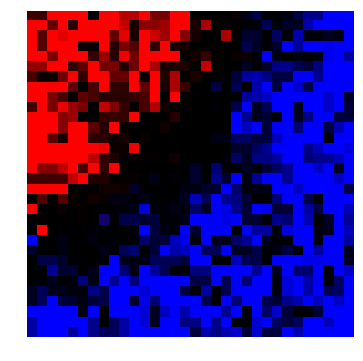

In [96]:
class BotConfig(object):
    def __init__(self):
        self.eat = 0.2
        self.fight = 0.2
        self.split = 0.2
        self.move = 0.2
        self.survive = 0.2

class Field(object):
    
    FOOD = np.array([0.4, 0.2, 0], dtype=np.float32)
    BOTS = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]], dtype=np.float32)
    EPS = 1e-3
    
    EAT_COEF = 0.1
    FEED_COEF = 5.0
    FIGHT_COEF = 0.5
    SPLIT_COEF = 0.5
    MOVE_COEF = 1.0
    SURVIVE_COEF = 0.001

    DX = [[1, 0], [0, 1], [-1, 0], [0, -1],]

    def __init__(self, bot_configs, n=32):
        self.n = 32
        self.f = np.random.uniform(size=[n, n]).astype(np.float32)
        self.bot_configs = bot_configs
        self.bots = np.zeros([n, n, 2], dtype=np.float32)
        self.bots[n // 4, n // 4, 0] = 1
        self.bots[n * 3 // 4, n * 3 // 4, 1] = 1
        self.img = np.zeros([n, n, 3], dtype=np.float32)
        
    def step(self):
        next_f = np.copy(self.f)
        next_bots = np.copy(self.bots)
        for k in range(2):
            mask = self.bots[:, :, k] > 0
            # EAT
            food_amount = self.bot_configs[k].eat * self.EAT_COEF
            next_f[mask] -= food_amount
            next_bots[:, :, k][mask] += np.minimum(food_amount, self.f[mask]) * self.FEED_COEF
            # FIGHT
            next_bots[:, :, 1 - k][mask] -= self.bot_configs[k].fight * self.FIGHT_COEF
            # SURVIVE
            next_bots[:, :, k][mask] -= self.SURVIVE_COEF / max(self.EPS, self.bot_configs[k].survive)

        self.f = next_f
        self.f[self.f < self.EPS] = 0
        next_bots[next_bots < self.EPS] = 0
        self.bots[:, :, :] = next_bots
        move_random = np.random.uniform(size=[self.n, self.n, 2]).astype(np.float32)
        for i in range(self.n):
            for j in range(self.n):
                for k in range(2):
                    if next_bots[i, j, k] > self.EPS and move_random[i, j, k] <= self.bot_configs[k].move * self.MOVE_COEF:
                        options = []
                        for d in self.DX:
                            ny, nx = i + d[0], j + d[1]
                            if ny >= 0 and nx >= 0 and ny < self.n and nx < self.n and self.bots[ny, nx, k] < self.EPS:
                                options.append((ny, nx))
                        if len(options) > 0:
                            ny, nx = options[np.random.randint(0, len(options))]
                            self.bots[ny, nx, k] = next_bots[i, j, k]
                            self.bots[i, j, k] = 0
        
        next_bots[:, :, :] = self.bots
        split_random = np.random.uniform(size=[self.n, self.n, 2]).astype(np.float32)
        # SPLIT
        for i in range(self.n):
            for j in range(self.n):
                for k in range(2):
                    if next_bots[i, j, k] > self.EPS * 2 and split_random[i, j, k] <= self.bot_configs[k].split * self.SPLIT_COEF:
                        options = []
                        for d in self.DX:
                            ny, nx = i + d[0], j + d[1]
                            if ny >= 0 and nx >= 0 and ny < self.n and nx < self.n and self.bots[ny, nx, k] < self.EPS:
                                options.append((ny, nx))
                        if len(options) > 0:
                            ny, nx = options[np.random.randint(0, len(options))]
                            health = next_bots[i, j, k] * 0.5
                            self.bots[ny, nx, k] = health
                            self.bots[i, j, k] = health
    
    def draw(self, draw_index):
        if draw_index != self.last_draw_index:
            self.last_draw_index = draw_index
            self.step()
        self.img[:, :, :] = self.f[:, :, np.newaxis] * self.FOOD[np.newaxis, np.newaxis, :]
        self.img[:, :, :] += self.bots[:, :, :1] * self.BOTS[np.newaxis, np.newaxis, 0, :]
        self.img[:, :, :] += self.bots[:, :, 1:] * self.BOTS[np.newaxis, np.newaxis, 1, :]
        self.img = np.clip(self.img, 0, 1)
        return (self.ax.imshow(self.img),)

    def animate(self):
        self.last_draw_index = -1
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.axis('off')
        self.ax = ax
        return animation.FuncAnimation(fig, self.draw,
                               frames=300, interval=100, blit=True)
    
Field([BotConfig(), BotConfig(),]).animate()